# Wind Energy Potential Analysis in Ireland
## Using Long-Term Meteorological Data

### Introduction

This notebook analyses long-term wind data from four Irish meteorological stations to assess wind energy potential. The study examines seasonal variability, wind usability for turbines, and long-term trends to determine Ireland’s suitability for wind power generation.

Stations analysed:

| Station              | Notes          |
| -------------------- | -------------- |
| Malin Head           | Northern coast |
| Mace Head            | Western coast  |
| Valentia Observatory | Southwest      |
| Dublin Airport       | Eastern inland |



### Data Sources and Stations 

Daily meteorological data were obtained from Met Éireann. Variables used include:

* Mean wind speed (wdsp)

* Highest 10-minute mean wind speed (hm)

* Maximum gust (hg)

* Dominant wind direction (ddhm)

The CSV files for each station can be accessed at the following URLs:

* Malin Head: [dly1575.csv](https://cli.fusio.net/cli/climate_data/webdata/dly1575.csv)

* Mace Head: [dly275.csv](https://cli.fusio.net/cli/climate_data/webdata/dly275.csv)

* Valentia Observatory: [dly2275.csv](https://cli.fusio.net/cli/climate_data/webdata/dly2275.csv)

* Dublin Airport: [dly532.csv](https://cli.fusio.net/cli/climate_data/webdata/dly532.csv)

## Data Loading and Preparation

### Import libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress


In [16]:

# Load and combine station data


# URLs for Met Éireann climate data CSV files
stations = {
    "Malin Head": "https://cli.fusio.net/cli/climate_data/webdata/dly1575.csv",
    "Mace Head": "https://cli.fusio.net/cli/climate_data/webdata/dly275.csv",
    "Valentia Observatory": "https://cli.fusio.net/cli/climate_data/webdata/dly2275.csv",
    "Dublin Airport": "https://cli.fusio.net/cli/climate_data/webdata/dly532.csv"
}

dfs = []
for station, url in stations.items():
    df = pd.read_csv(url, skiprows=24)
    df['station'] = station
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)


In [17]:

# Date handling and feature extraction

combined_df['date'] = pd.to_datetime(combined_df['date'], format='%d-%b-%Y', errors='coerce')

combined_df['year'] = combined_df['date'].dt.year
combined_df['month'] = combined_df['date'].dt.month
combined_df['week'] = combined_df['date'].dt.isocalendar().week


In [18]:
# Convert variables to numeric
combined_df['wdsp_numeric'] = pd.to_numeric(combined_df['wdsp'], errors='coerce')
combined_df['wind_speed_ms'] = combined_df['wdsp_numeric'] * 0.514444

combined_df['hm_numeric'] = pd.to_numeric(combined_df['hm'], errors='coerce') * 0.514444
combined_df['hg_numeric'] = pd.to_numeric(combined_df['hg'], errors='coerce')
combined_df['ddhm_numeric'] = pd.to_numeric(combined_df['ddhm'], errors='coerce')


In [19]:
# Handle missing values per station

cols = ['wind_speed_ms', 'hm_numeric', 'hg_numeric', 'ddhm_numeric']
combined_df[cols] = combined_df.groupby('station')[cols].transform(lambda x: x.bfill().ffill())


### Exploratory Data Analysis

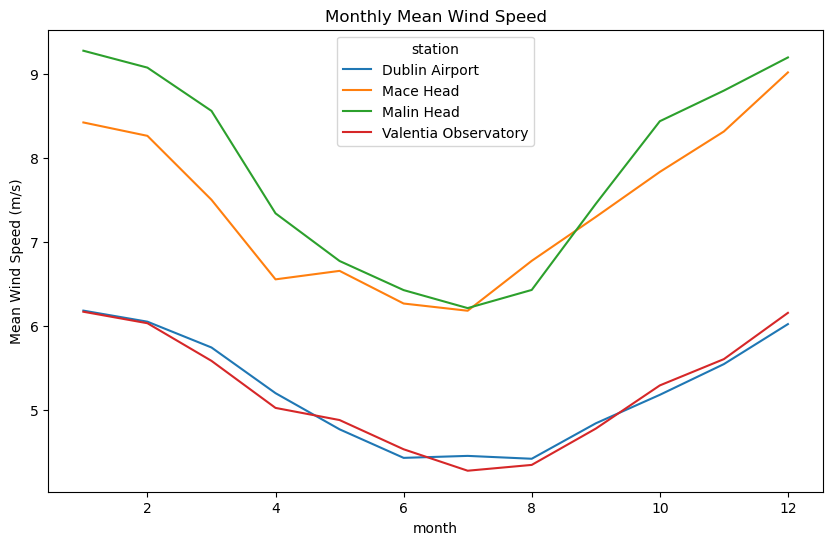

In [20]:
# Monthly mean wind speed
monthly_wind = combined_df.groupby(['station','month'])['wind_speed_ms'].mean().unstack()
monthly_wind.T.plot(figsize=(10,6))
plt.ylabel('Mean Wind Speed (m/s)')
plt.title('Monthly Mean Wind Speed')
plt.show()


### Observation 

- Gusts are higher in winter months; coastal stations experience stronger gusts.

### Wind Energy Potential Analysis

Wind turbines have three key constraints:

| Constraint    | Value      | Notes                                      |
| ------------- | ---------- | ------------------------------------------ |
| Cut-in speed  | ~3 m/s     | Below this, turbine doesn’t generate power |
| Rated speed   | ~12–15 m/s | Output reaches maximum capacity            |
| Cut-out speed | ~25 m/s    | Turbine shuts down for safety              |

We can use wind_speed_ms (daily mean), hm_numeric (highest 10-min mean), or hg_numeric (gusts) to assess how often wind is usable.

In [21]:
# Define seasons

def season(month):
    if month in [12,1,2]:
        return 'Winter'
    elif month in [3,4,5]:
        return 'Spring'
    elif month in [6,7,8]:
        return 'Summer'
    else:
        return 'Autumn'

combined_df['season'] = combined_df['month'].apply(season)


In [22]:
# Seasonal usable wind percentage

cut_in, cut_out = 3, 25

seasonal_usable = combined_df.groupby(['station','season'])['wind_speed_ms'].apply(
    lambda x: ((x >= cut_in) & (x <= cut_out)).mean() * 100
).unstack()

seasonal_usable


season,Autumn,Spring,Summer,Winter
station,,,,
Dublin Airport,82.679226,83.333333,75.841097,88.437086
Mace Head,95.060533,93.746898,91.056511,94.590495
Malin Head,96.300882,93.988564,90.661359,98.132320
Valentia Observatory,78.532182,79.008671,73.563665,84.370861


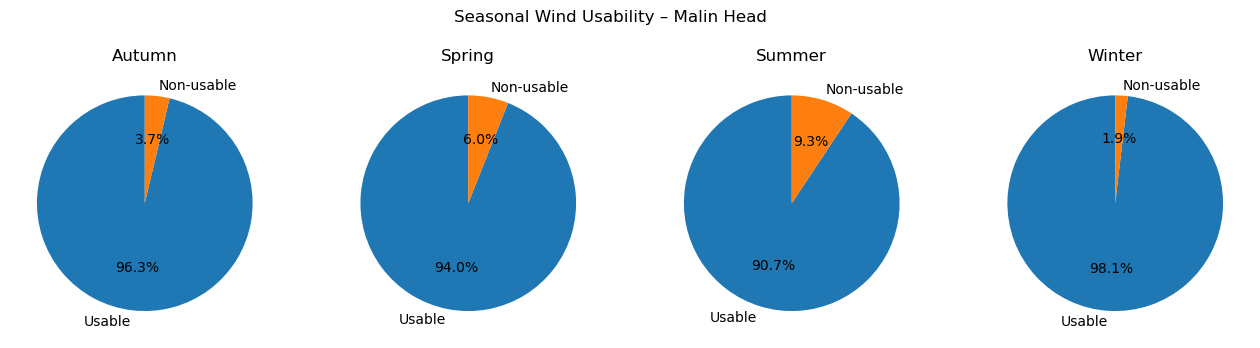

In [23]:
# Seasonal pie charts
station = 'Malin Head'

usable = seasonal_usable.loc[station]
non_usable = 100 - usable

fig, axes = plt.subplots(1, 4, figsize=(16,4))
for i, s in enumerate(usable.index):
    axes[i].pie([usable[s], non_usable[s]],
                labels=['Usable','Non-usable'],
                autopct='%1.1f%%',
                startangle=90)
    axes[i].set_title(s)

plt.suptitle(f'Seasonal Wind Usability – {station}')
plt.show()



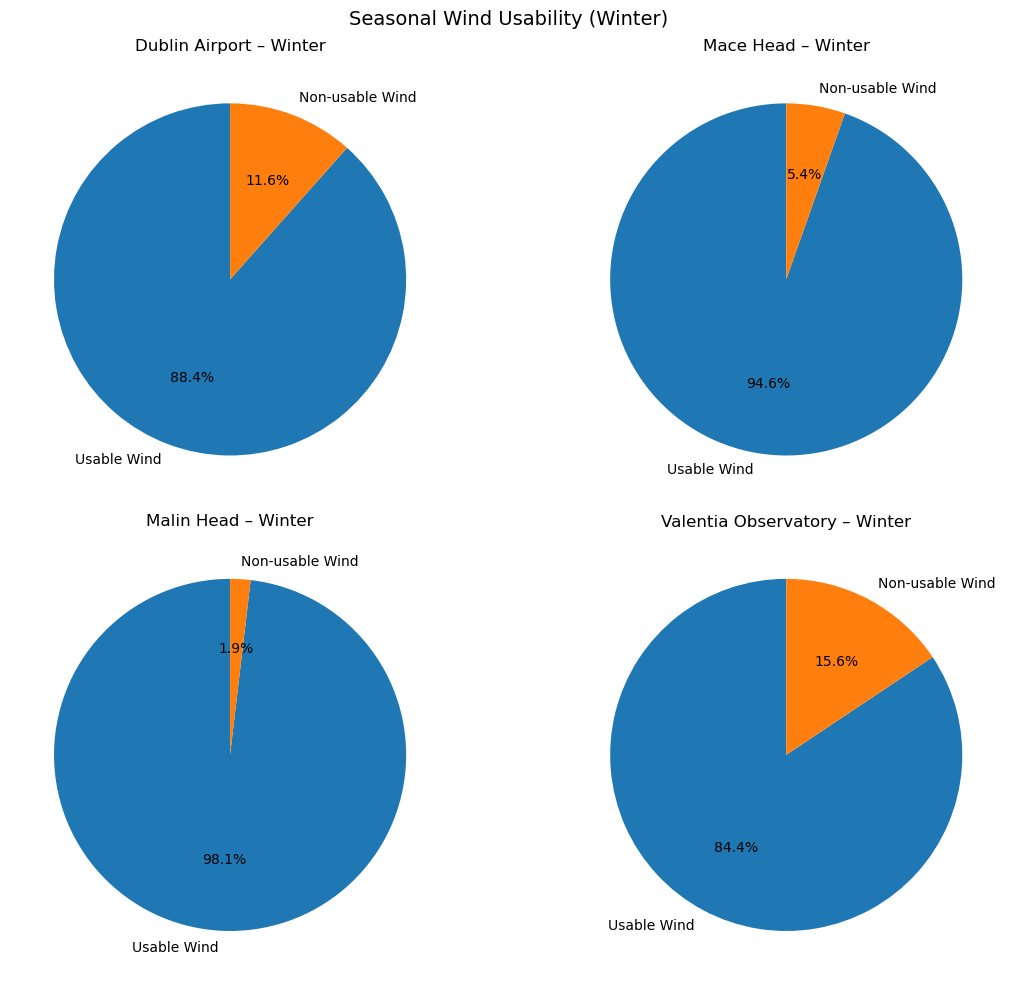

In [24]:
# Plot seasonal usable wind as pie charts

season_to_plot = 'Winter'  # Choose one season: 'Winter', 'Spring', 'Summer', or 'Autumn'

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, station in enumerate(seasonal_usable.index):
    usable_pct = seasonal_usable.loc[station, season_to_plot]
    non_usable_pct = 100 - usable_pct
    
    axes[i].pie(
        [usable_pct, non_usable_pct],
        labels=['Usable Wind', 'Non-usable Wind'],
        autopct='%1.1f%%',
        startangle=90
    )
    
    axes[i].set_title(f'{station} – {season_to_plot}')

plt.suptitle(f'Seasonal Wind Usability ({season_to_plot})', fontsize=14)
plt.tight_layout()
plt.show()


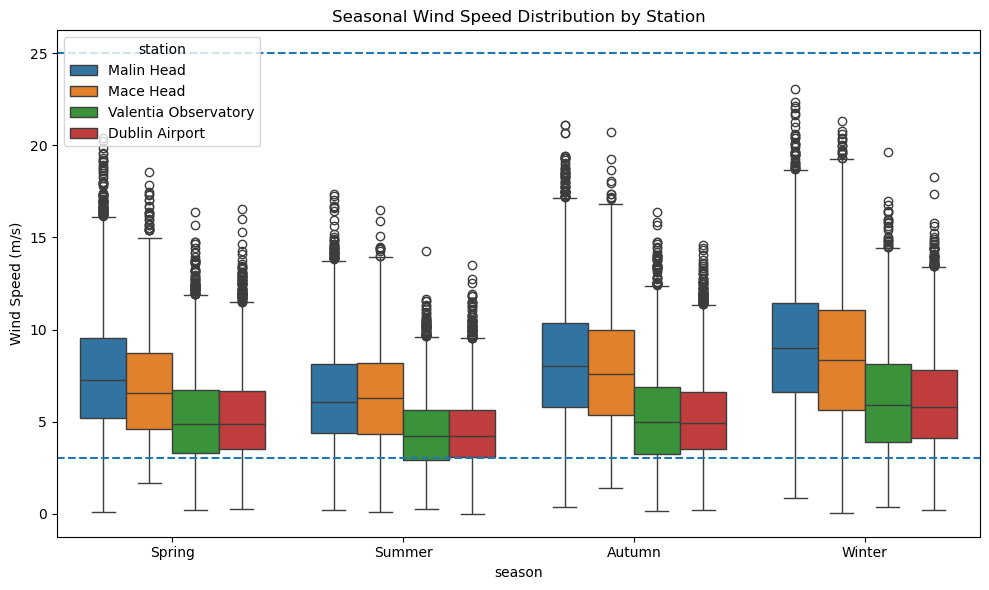

In [25]:
# Boxplot of wind speeds by season and station

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=combined_df,
    x='season',
    y='wind_speed_ms',
    hue='station'
)
plt.axhline(3, linestyle='--')
plt.axhline(25, linestyle='--')
plt.ylabel('Wind Speed (m/s)')
plt.title('Seasonal Wind Speed Distribution by Station')
plt.tight_layout()
plt.show()

### Observations:

- Coastal stations (Malin Head, Mace Head) are windier year-round than inland.

- Wind speeds and gusts peak in winter, drop in summer.

- Wind direction is relatively consistent at coastal stations, more variable inland.

- Temperature patterns show coastal moderation vs inland extremes.

- Weekly, monthly, and yearly aggregation reveals both seasonal patterns and long-term trends.

### Trend Analysis

In [26]:
# Yearly mean wind speed 
yearly_wind = combined_df.groupby(['station','year'])['wind_speed_ms'].mean().unstack()
yearly_wind


year,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
station,,,,,,,,,,,,,,,,,,,,,
Dublin Airport,6.153314,6.881569,5.630491,5.263255,5.791653,5.120480,5.423308,5.280732,5.504974,5.628017,...,5.398570,5.637742,5.138238,4.676648,4.956092,4.437467,4.655084,4.623654,4.745676,4.454715
Mace Head,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.391970,7.517225,7.503694,7.701861,8.014503,6.830830,7.565709,7.451545,7.287535,7.343765
Malin Head,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.375525,7.755560,7.630684,7.530333,7.942116,7.065360,7.621664,7.462821,7.662826,7.327592
Valentia Observatory,5.800250,6.303560,5.638784,5.702858,5.831822,5.802646,6.002409,5.499618,5.553317,4.922454,...,4.718829,4.806457,4.833378,5.113432,5.261244,4.474817,4.813082,4.904695,4.714612,4.674047


In [27]:
#Linear trend analysis
trend_results = {}

for station in yearly_wind.index:
    y = yearly_wind.loc[station].dropna()
    x = y.index.values
    slope, intercept, r, p, _ = linregress(x, y.values)
    
    trend_results[station] = {
        'Slope (m/s per year)': slope,
        'R²': r**2,
        'p-value': p
    }

pd.DataFrame(trend_results).T


,Slope (m/s per year),R²,p-value
Dublin Airport,-0.002254,0.014979,2.674015e-01
Mace Head,0.010458,0.030105,4.285096e-01
Malin Head,0.001643,0.002780,6.623164e-01
Valentia Observatory,-0.011836,0.343188,4.804214e-09


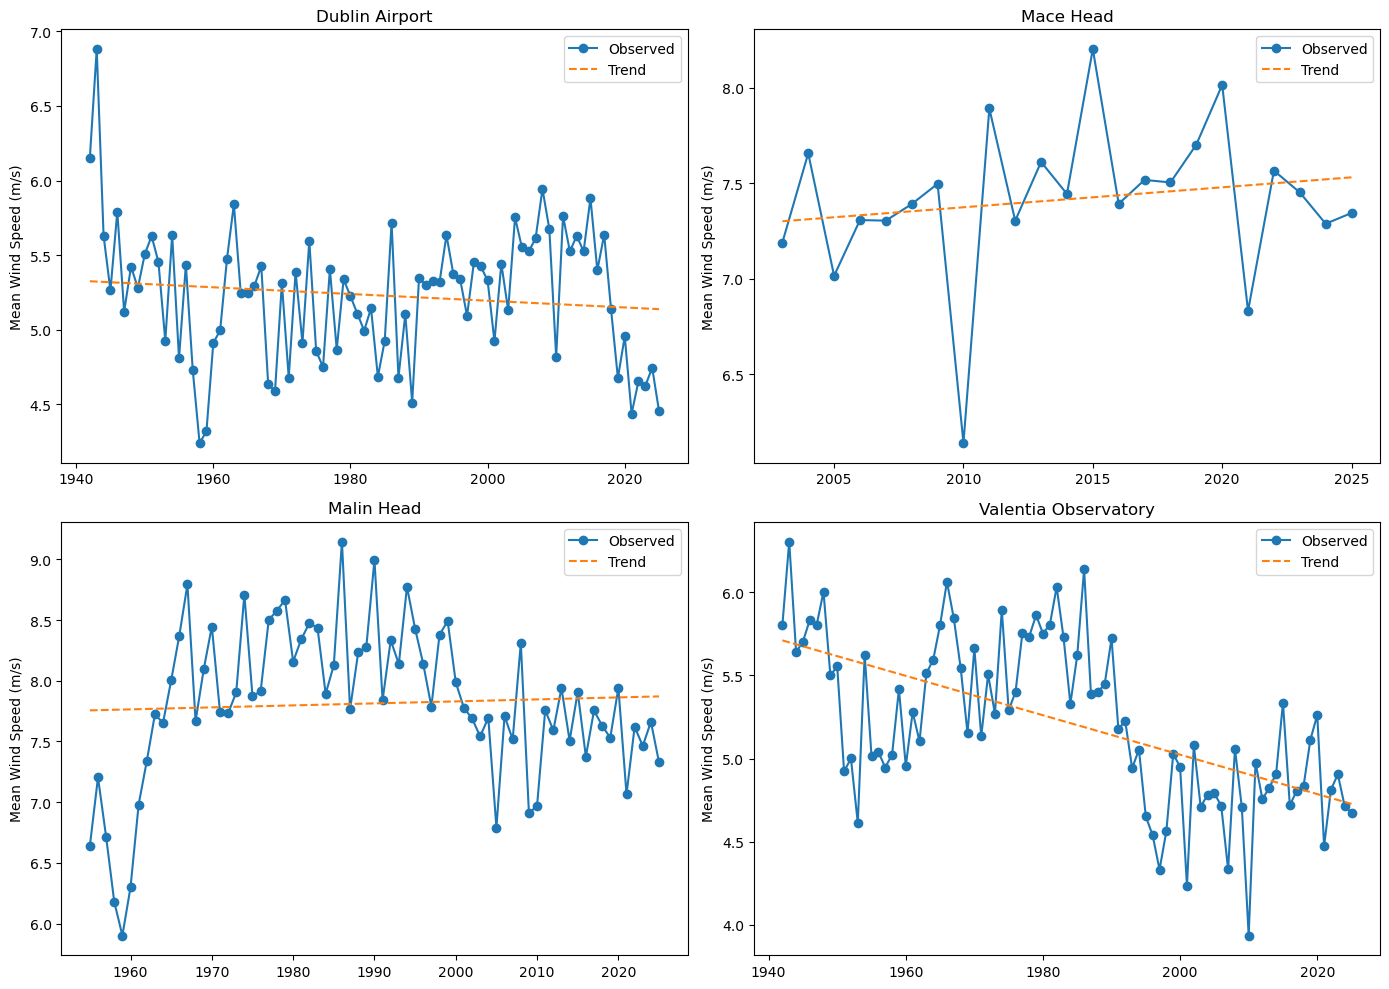

In [28]:
# Trend plots

fig, axes = plt.subplots(2,2, figsize=(14,10))
axes = axes.flatten()

for i, station in enumerate(yearly_wind.index):
    y = yearly_wind.loc[station].dropna()
    x = y.index.values
    slope, intercept, *_ = linregress(x, y.values)
    
    axes[i].plot(x, y, marker='o', label='Observed')
    axes[i].plot(x, intercept + slope*x, linestyle='--', label='Trend')
    axes[i].set_title(station)
    axes[i].set_ylabel('Mean Wind Speed (m/s)')
    axes[i].legend()

plt.tight_layout()
plt.show()


Interpretation 



- A positive slope indicates increasing wind speed and improving wind energy potential.

- A negative slope suggests weakening winds.

- Low p-values (< 0.05) indicate statistically significant trends.


### Discussion 

* Coastal stations show consistently higher wind speeds than inland stations.

* Winter provides the highest wind energy potential.

* Long-term trends are generally stable, with no strong decline in wind resources.

* Seasonal variability has a greater impact than long-term trends.

### Conclusion 


Trend analysis reveals modest long-term changes in wind speed across Ireland. While Dublin Airport and Valentia Observatory show slight decreases, coastal stations such as Mace Head and Malin Head remain stable or exhibit weak positive trends. Overall, Ireland’s wind resource remains robust, with seasonal variability playing a more significant role than long-term change.